# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
env.brains[env.brain_names[0]]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
# define class of QNetwork

import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle 


class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units = 128, fc2_units = 64):
        
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# define class of Agent

class Agent():
    
    def __init__(self, state_size, action_size, seed, fc1_units, fc2_units):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.fc1_units = fc1_units
        self.fc2_units = fc2_units
        
        self.qnetwork_local = QNetwork(state_size, action_size, seed, self.fc1_units, self.fc2_units).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, self.fc1_units, self.fc2_units).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = LR)
        
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
    
    def act(self, state, eps = 0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()).astype(int) 
        else:
            return random.choice(np.arange(self.action_size)).astype(int) 
    
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1- dones))
        
        Q_expected = self.qnetwork_local(states).gather(1, actions.long())
        
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
    
    def soft_update(self, local_model, target_model, tau):
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1-tau) * target_param.data)

# define class of ReplayBuffer

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
#         self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

In [7]:
#define function to apply the dqn
import time
def dqn(agent, env,  filename, n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.99):
    start_time = time.time()
    
    scores = []
    scores_window = deque(maxlen = 100)
    eps = eps_start
    value = 10
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode = True)['BananaBrain']
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]   
            
            #next_state, reward, done, _ = env.step(action)
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            if done:
                break
        
        scores_window.append(score) ##always keep the last 100 values. extra will be pop out automatically
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 200 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= value:
            value = np.mean(scores_window)
            #print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), filename)
    end_time = time.time()
    print("Used time=", end_time - start_time)
    return scores


### 5. Test different parameter settings

#### 5.1 change the network size

The network has three fully-connected layer and use Relu as activation function.  
Following network sizes combination have been tested:  
fc1_units = 128, fc2_units = 64  
fc1_units = 64, fc2_units = 64  
fc1_units = 64, fc2_units = 32

Weights data will be saved whenever the scores increased.

In [19]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 1e-3
UPDATE_EVERY = 8
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
brain_name = env.brain_names[0]

In [20]:
agent = Agent(state_size = 37, action_size = 4, seed = 0, fc1_units = 128, fc2_units = 64)
md1_scores = dqn(agent, env, filename = "fc1_128_fc2_64.pth", n_episodes =2000)
pickle.dump(md1_scores, open("fc1_128_fc2_64_scores.pkl", "wb"))

Episode 200	Average Score: 3.60
Episode 400	Average Score: 8.00
Episode 600	Average Score: 11.79
Episode 800	Average Score: 13.61
Episode 1000	Average Score: 14.66
Episode 1200	Average Score: 15.90
Episode 1400	Average Score: 15.74
Episode 1600	Average Score: 15.00
Episode 1800	Average Score: 15.75
Episode 2000	Average Score: 15.54
Used time= 2325.5371096134186


In [21]:
agent = Agent(state_size = 37, action_size = 4, seed = 0, fc1_units = 64, fc2_units = 64)
md2_scores = dqn(agent, env, filename = "fc1_64_fc2_64.pth", n_episodes =2000)
pickle.dump(md2_scores, open("fc1_64_fc2_64_scores.pkl", "wb"))

Episode 200	Average Score: 4.68
Episode 400	Average Score: 9.12
Episode 600	Average Score: 13.39
Episode 800	Average Score: 14.43
Episode 1000	Average Score: 14.66
Episode 1200	Average Score: 14.98
Episode 1400	Average Score: 15.82
Episode 1600	Average Score: 15.22
Episode 1800	Average Score: 16.30
Episode 2000	Average Score: 16.01
Used time= 2416.5075690746307


In [22]:
agent = Agent(state_size = 37, action_size = 4, seed = 0, fc1_units = 64, fc2_units = 32)
md3_scores = dqn(agent, env, filename = "fc1_64_fc2_32.pth", n_episodes =2000)
pickle.dump(md3_scores, open("fc1_64_fc2_32_scores.pkl", "wb"))

Episode 200	Average Score: 4.51
Episode 400	Average Score: 9.46
Episode 600	Average Score: 13.35
Episode 800	Average Score: 14.53
Episode 1000	Average Score: 15.26
Episode 1200	Average Score: 16.35
Episode 1400	Average Score: 14.67
Episode 1600	Average Score: 15.99
Episode 1800	Average Score: 15.97
Episode 2000	Average Score: 14.80
Used time= 2416.961259365082


#### 5.2 change learning rate

With the NN (fc1_units = 64, fc2_units = 32), test different learning rate.
lr = 0.0005
lr = 0.0001

In [8]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
UPDATE_EVERY = 8
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
brain_name = env.brain_names[0]

In [9]:
LR = 5e-4
agent = Agent(state_size = 37, action_size = 4, seed = 0, fc1_units = 64, fc2_units = 32)
md4_scores = dqn(agent, env, filename = "lr_5e_4.pth", n_episodes =2000)
pickle.dump(md4_scores, open("lr_5e_4.pkl", "wb"))

Episode 200	Average Score: 2.38
Episode 400	Average Score: 10.02
Episode 600	Average Score: 12.34
Episode 800	Average Score: 16.25
Episode 1000	Average Score: 16.50
Episode 1200	Average Score: 14.94
Episode 1400	Average Score: 16.07
Episode 1600	Average Score: 15.92
Episode 1800	Average Score: 15.51
Episode 2000	Average Score: 15.82
Used time= 2426.702438354492


In [10]:
LR = 1e-4
agent = Agent(state_size = 37, action_size = 4, seed = 0, fc1_units = 64, fc2_units = 32)
md5_scores = dqn(agent, env, filename = "lr_1e_4.pth", n_episodes =2000)
pickle.dump(md5_scores, open("lr_1e_4.pkl", "wb"))

Episode 200	Average Score: 3.15
Episode 400	Average Score: 8.24
Episode 600	Average Score: 11.77
Episode 800	Average Score: 14.68
Episode 1000	Average Score: 14.61
Episode 1200	Average Score: 15.50
Episode 1400	Average Score: 15.11
Episode 1600	Average Score: 15.53
Episode 1800	Average Score: 16.32
Episode 2000	Average Score: 16.08
Used time= 2487.1495003700256


#### 5.3 change update rate

update rate = [4, 16]

In [11]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 1e-3

    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
brain_name = env.brain_names[0]

In [12]:
UPDATE_EVERY = 4
agent = Agent(state_size = 37, action_size = 4, seed = 0, fc1_units = 64, fc2_units = 32)
md6_scores = dqn(agent, env, filename = "update_every4.pth", n_episodes =2000)
pickle.dump(md6_scores, open("update_every4.pkl", "wb"))

Episode 200	Average Score: 6.15
Episode 400	Average Score: 12.19
Episode 600	Average Score: 14.30
Episode 800	Average Score: 14.52
Episode 1000	Average Score: 15.06
Episode 1200	Average Score: 15.15
Episode 1400	Average Score: 14.39
Episode 1600	Average Score: 14.52
Episode 1800	Average Score: 14.99
Episode 2000	Average Score: 15.26
Used time= 2990.1192705631256


In [13]:
UPDATE_EVERY = 16
agent = Agent(state_size = 37, action_size = 4, seed = 0, fc1_units = 64, fc2_units = 32)
md7_scores = dqn(agent, env, filename = "update_every16.pth", n_episodes =2000)
pickle.dump(md7_scores, open("update_every16.pkl", "wb"))

Episode 200	Average Score: 0.421
Episode 400	Average Score: 2.66
Episode 600	Average Score: 5.82
Episode 800	Average Score: 8.27
Episode 1000	Average Score: 10.17
Episode 1200	Average Score: 13.39
Episode 1400	Average Score: 14.50
Episode 1600	Average Score: 16.11
Episode 1800	Average Score: 15.51
Episode 2000	Average Score: 15.86
Used time= 2001.9102759361267


## 6. compare results

### 6.1 different NN size

In [11]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
md1_scores = pickle.load(open("fc1_128_fc2_64_scores.pkl", "rb"))
md2_scores = pickle.load(open("fc1_64_fc2_64_scores.pkl", "rb"))
md3_scores = pickle.load(open("fc1_64_fc2_32_scores.pkl", "rb"))

In [9]:
# apply moving average to remove the noisy
md1_scores_rolling = pd.Series(md1_scores).rolling(window=100).mean()
md2_scores_rolling = pd.Series(md2_scores).rolling(window=100).mean()
md3_scores_rolling = pd.Series(md3_scores).rolling(window=100).mean()

Text(0, 0.5, 'score')

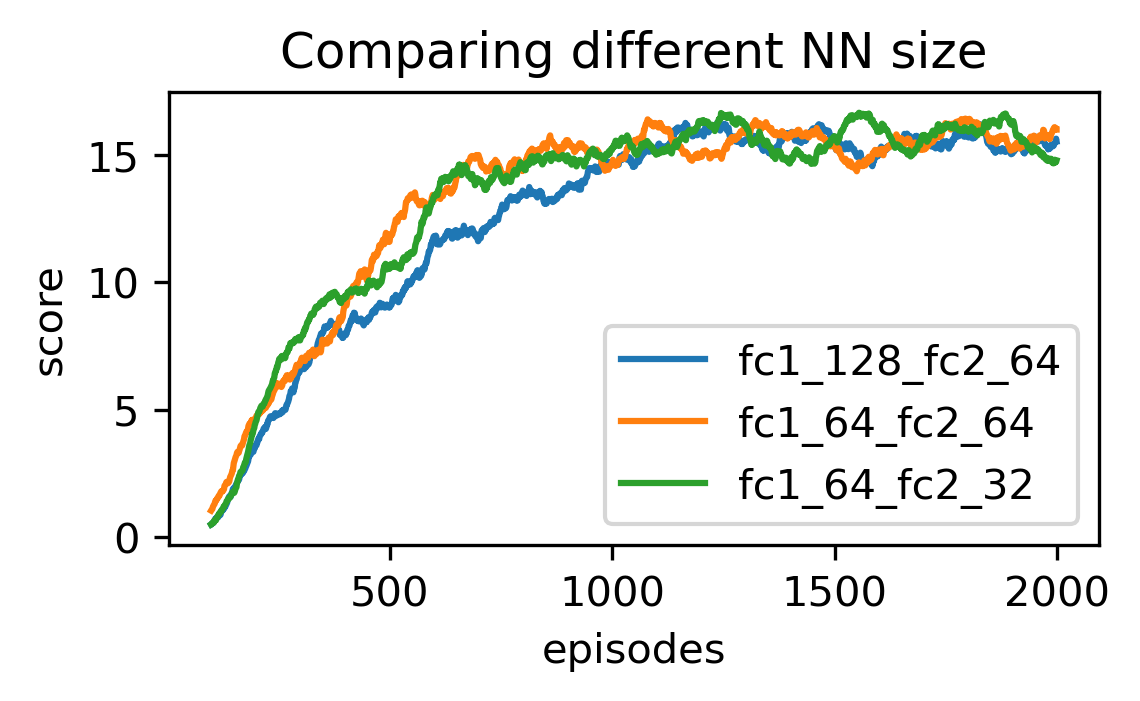

In [13]:
plt.figure(figsize = (4, 2))
plt.plot(list(range(2000)), md1_scores_rolling, label = "fc1_128_fc2_64")
plt.plot(list(range(2000)), md2_scores_rolling, label = "fc1_64_fc2_64")
plt.plot(list(range(2000)), md3_scores_rolling, label = "fc1_64_fc2_32")
plt.title("Comparing different NN size")
plt.legend()
plt.xlabel("episodes")
plt.ylabel("score")

### 6.2 change learning rate

In [14]:
md4_scores = pickle.load(open("lr_5e_4.pkl", "rb"))
md5_scores = pickle.load(open("lr_1e_4.pkl", "rb"))

In [16]:
md4_scores_rolling = pd.Series(md4_scores).rolling(window = 100).mean()
md5_scores_rolling = pd.Series(md5_scores).rolling(window = 100).mean()

Text(0, 0.5, 'score')

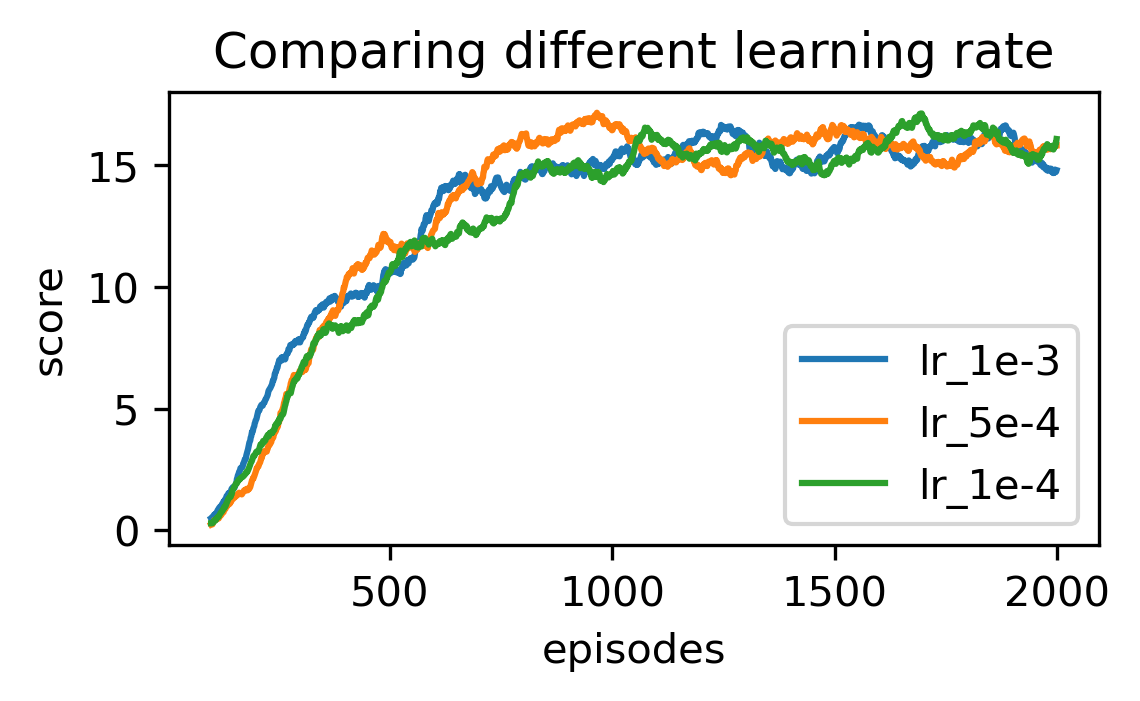

In [17]:
plt.figure(figsize = (4, 2))
plt.plot(list(range(2000)), md3_scores_rolling, label = "lr_1e-3")
plt.plot(list(range(2000)), md4_scores_rolling, label = "lr_5e-4")
plt.plot(list(range(2000)), md5_scores_rolling, label = "lr_1e-4")
plt.title("Comparing different learning rate")
plt.legend()
plt.xlabel("episodes")
plt.ylabel("score")

### 6.3 change update frequency

In [18]:
md6_scores = pickle.load(open("update_every4.pkl", "rb"))
md7_scores = pickle.load(open("update_every16.pkl", "rb"))

In [19]:
md6_scores_rolling = pd.Series(md6_scores).rolling(window = 100).mean()
md7_scores_rolling = pd.Series(md7_scores).rolling(window = 100).mean()

Text(0, 0.5, 'score')

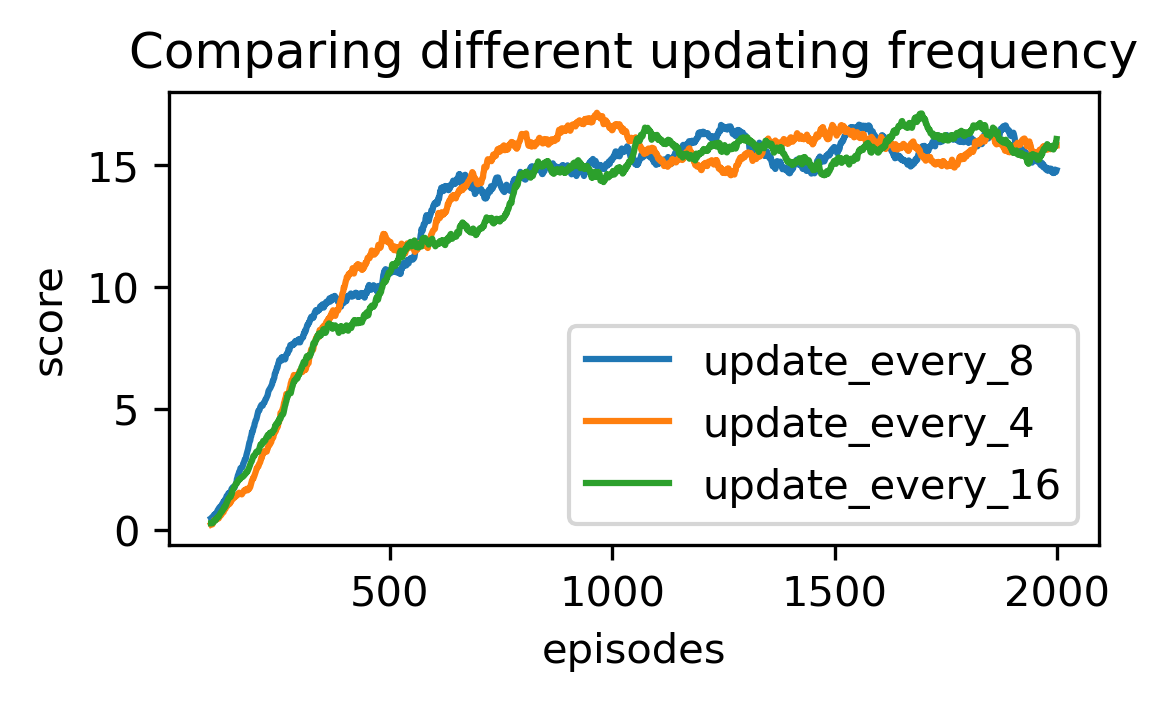

In [20]:
plt.figure(figsize = (4, 2))
plt.plot(list(range(2000)), md3_scores_rolling, label = "update_every_8")
plt.plot(list(range(2000)), md4_scores_rolling, label = "update_every_4")
plt.plot(list(range(2000)), md5_scores_rolling, label = "update_every_16")
plt.title("Comparing different updating frequency")
plt.legend()
plt.xlabel("episodes")
plt.ylabel("score")